# Exploración y Visualización de Datos de Producción Petrolera

## Sesión 02 - Módulo 02 - Laboratorio 2
### Bootcamp: Machine Learning Aplicado a la Industria Petrolera

## Objetivos de Aprendizaje
- Aplicar técnicas de análisis exploratorio a datos de producción petrolera
- Identificar patrones, tendencias y anomalías en series temporales de producción
- Crear visualizaciones para datos de la industria petrolera
- Extraer insights preliminares para optimización de producción

## Introducción

El análisis exploratorio de datos (EDA) es una etapa crítica en cualquier proyecto de Machine Learning, especialmente en la industria petrolera donde los datos son complejos y multidimensionales. Un EDA efectivo permite identificar patrones ocultos, correlaciones entre variables y comportamientos anómalos que pueden tener un impacto significativo en la producción.

In [1]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías importadas correctamente")

Librerías importadas correctamente


# PARTE 1: CARGA Y PREPARACIÓN DE DATOS PETROLEROS

Para este laboratorio, crearemos un dataset sintético de producción petrolera que nos permitirá aplicar técnicas de análisis exploratorio sin necesidad de datos reales.

In [2]:
# Función para crear un dataset sintético de producción petrolera
def create_synthetic_production_data(n_wells=5, days=365, seed=42):
    """
    Crea un dataset sintético de producción petrolera.
    
    Parámetros:
    -----------
    n_wells : int, default=5
        Número de pozos a simular
    days : int, default=365
        Número de días de datos a generar
    seed : int, default=42
        Semilla para reproducibilidad
        
    Retorna:
    --------
    DataFrame con datos sintéticos de producción
    """
    np.random.seed(seed)
    
    # Crear rango de fechas
    start_date = datetime(2022, 1, 1)
    dates = [start_date + timedelta(days=i) for i in range(days)]
    
    # Inicializar lista para almacenar datos
    data = []
    
    # Generar datos para cada pozo
    for well_id in range(1, n_wells + 1):
        # Parámetros base del pozo (cada pozo tendrá características diferentes)
        initial_production = np.random.uniform(800, 2000)  # Producción inicial (bbl/día)
        decline_rate = np.random.uniform(0.001, 0.004)     # Tasa de declinación diaria
        pressure_base = np.random.uniform(1800, 3000)      # Presión base (psi)
        water_cut_base = np.random.uniform(10, 50)         # Water cut base (%)
        gor_base = np.random.uniform(400, 1000)            # Gas-oil ratio base
        
        # Parámetros de variabilidad
        production_noise = np.random.uniform(0.05, 0.15)   # Ruido en producción
        pressure_noise = np.random.uniform(20, 100)        # Ruido en presión
        water_cut_growth = np.random.uniform(0.01, 0.05)   # Aumento diario en water cut
        
        # Generar series temporales
        for i, date in enumerate(dates):
            # Calcular valores con componentes de tendencia y ruido
            production = initial_production * np.exp(-decline_rate * i) * (1 + np.random.normal(0, production_noise))
            pressure = pressure_base - i * 0.5 + np.random.normal(0, pressure_noise)
            water_cut = min(95, water_cut_base + i * water_cut_growth * 0.1 + np.random.normal(0, 2))
            gor = gor_base + i * 0.2 + np.random.normal(0, 20)
            
            # Añadir eventos especiales (workovers, shutdowns, etc.)
            if np.random.random() < 0.01:  # 1% de probabilidad de shutdown
                production = 0
                pressure = 0
            elif np.random.random() < 0.02:  # 2% de probabilidad de workover
                production = production * 1.3  # Incremento de producción después de workover
            
            # Añadir valores faltantes ocasionales
            if np.random.random() < 0.03:  # 3% de probabilidad de valor faltante
                production = np.nan
            
            # Añadir registro a la lista
            data.append({
                'date': date,
                'well_id': f'WELL-{well_id:03d}',
                'production': production,
                'pressure': pressure,
                'water_cut': water_cut,
                'gas_oil_ratio': gor,
                'field': f'FIELD-{(well_id-1)//2 + 1:02d}'  # Agrupar pozos en campos
            })
    
    # Convertir a DataFrame
    df = pd.DataFrame(data)
    
    # Configurar fecha como índice
    df['date'] = pd.to_datetime(df['date'])
    
    # Añadir algunas características derivadas
    df['oil_rate'] = df['production'] * (1 - df['water_cut']/100)
    df['water_rate'] = df['production'] * (df['water_cut']/100)
    df['gas_rate'] = df['oil_rate'] * df['gas_oil_ratio']
    
    return df

# Crear datos sintéticos
production_data = create_synthetic_production_data(n_wells=7, days=365)

# Mostrar primeras filas
print("\nMuestra de datos de producción generados:")
print(production_data.head())

# Mostrar estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(production_data.describe())


Muestra de datos de producción generados:
        date   well_id   production     pressure  water_cut  gas_oil_ratio  \
0 2022-01-01  WELL-001  1378.885342  2697.307455  33.007391     504.462385   
1 2022-01-02  WELL-001  1031.334980  2701.316196  35.583694     463.333664   
2 2022-01-03  WELL-001  1359.066206  2671.828092  34.090325     465.516221   
3 2022-01-04  WELL-001  1186.458710  2700.243985  34.541801     481.499989   
4 2022-01-05  WELL-001  1296.730981  2646.302976  34.381925     455.217782   

      field    oil_rate  water_rate       gas_rate  
0  FIELD-01  923.751271  455.134071  465997.769542  
1  FIELD-01  664.347894  366.987086  307814.744131  
2  FIELD-01  895.756117  463.310089  416989.002154  
3  FIELD-01  776.634498  409.824212  373949.502501  
4  FIELD-01  850.889903  445.841078  387340.214105  

Estadísticas descriptivas:
                                date   production     pressure    water_cut  \
count                           2555  2487.000000  2555.000000 

## Preparación de los datos

Realizaremos algunas tareas de preparación en los datos para facilitar nuestro análisis.

In [3]:
def prepare_petroleum_data(df):
    """Prepara datos de producción petrolera para análisis exploratorio."""
    # Hacer una copia para no modificar el original
    df_clean = df.copy()
    
    # Verificar valores faltantes
    missing_data = df_clean.isna().sum()
    cols_with_missing = missing_data[missing_data > 0]
    
    if len(cols_with_missing) > 0:
        print("Columnas con valores faltantes:")
        for col, count in cols_with_missing.items():
            percent = count / len(df_clean) * 100
            print(f"  • {col}: {count} valores ({percent:.1f}%)")
            
            # Rellenar valores faltantes con la mediana
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    # Añadir características temporales
    df_clean['month'] = df_clean['date'].dt.month
    df_clean['day_of_week'] = df_clean['date'].dt.dayofweek
    df_clean['quarter'] = df_clean['date'].dt.quarter
    df_clean['is_weekend'] = df_clean['day_of_week'].isin([5, 6]).astype(int)
    
    # Calcular métricas derivadas
    df_clean['liquid_rate'] = df_clean['oil_rate'] + df_clean['water_rate']
    
    # Calcular producción acumulada por pozo
    df_clean['cum_production'] = df_clean.groupby('well_id')['production'].transform('cumsum')
    
    return df_clean

# Preparar datos
prepared_data = prepare_petroleum_data(production_data)

# Verificar resultado
print("\nColumnas después de la preparación:")
print(prepared_data.columns.tolist())

Columnas con valores faltantes:
  • production: 68 valores (2.7%)
  • oil_rate: 68 valores (2.7%)
  • water_rate: 68 valores (2.7%)
  • gas_rate: 68 valores (2.7%)

Columnas después de la preparación:
['date', 'well_id', 'production', 'pressure', 'water_cut', 'gas_oil_ratio', 'field', 'oil_rate', 'water_rate', 'gas_rate', 'month', 'day_of_week', 'quarter', 'is_weekend', 'liquid_rate', 'cum_production']


# PARTE 2: ANÁLISIS EXPLORATORIO DE DATOS PETROLEROS

Ahora analizaremos los datos para identificar patrones, tendencias y relaciones entre variables.

## 2.1 Análisis de distribuciones y estadísticas

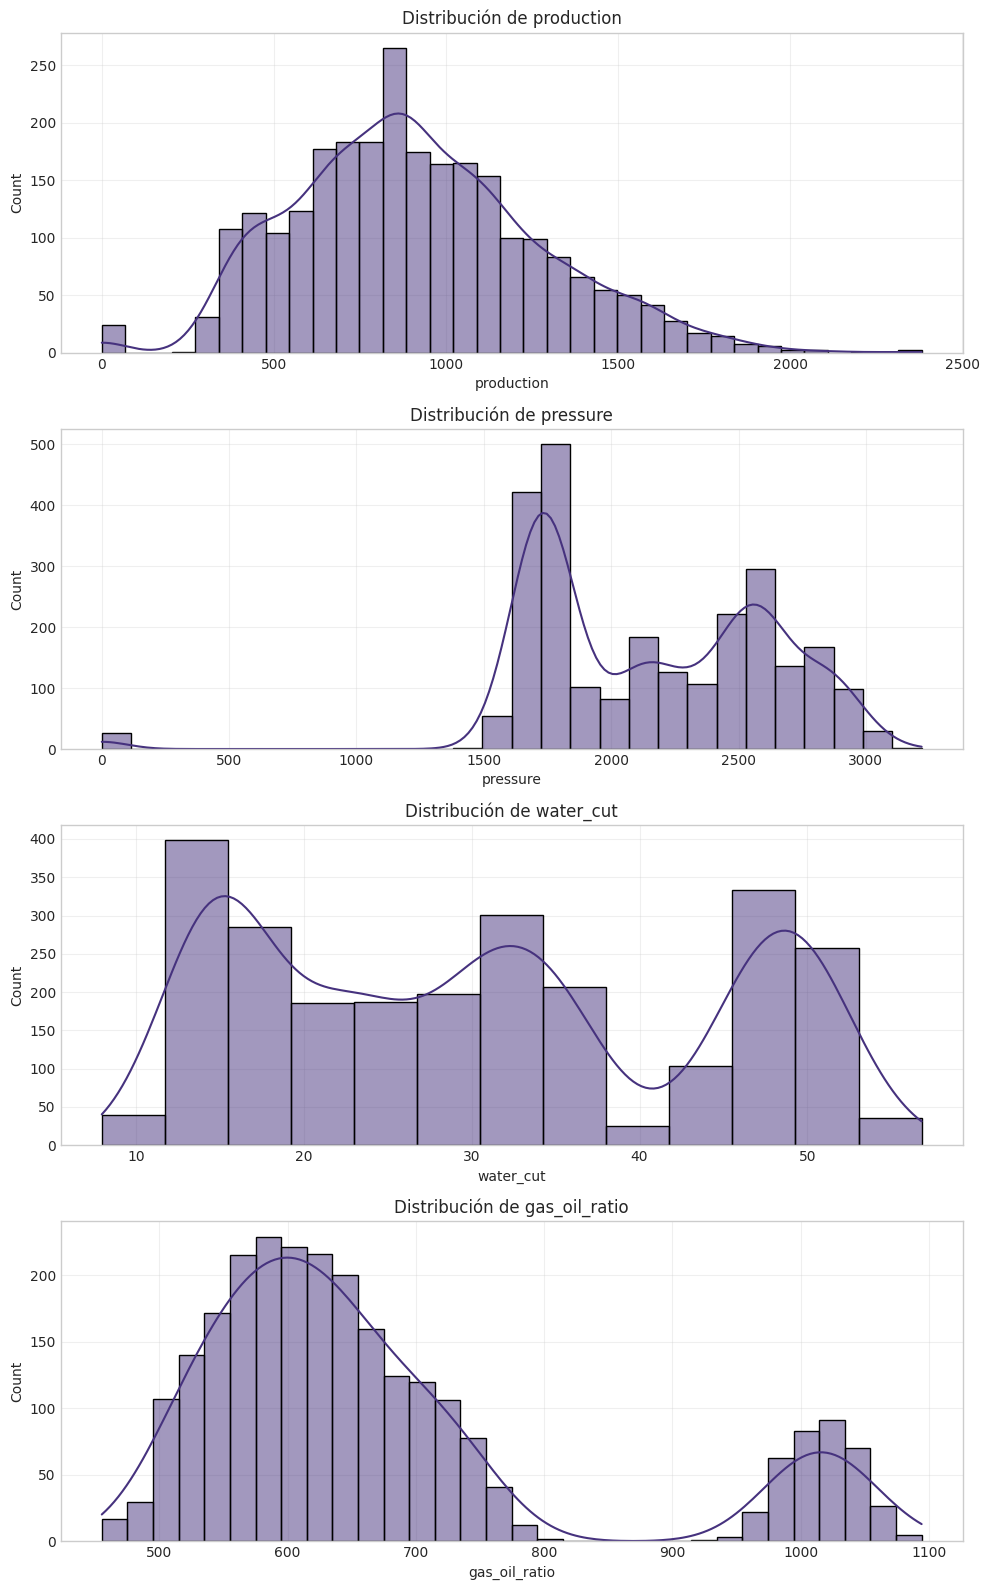


Estadísticas por campo:

production:
                 mean         std  min          max
field                                              
FIELD-01   874.348230  356.266100  0.0  2085.345867
FIELD-02   700.545475  259.740195  0.0  1676.227122
FIELD-03  1176.916886  339.513855  0.0  2381.300168
FIELD-04   881.282045  183.537062  0.0  1293.648106

pressure:
                 mean         std  min          max
field                                              
FIELD-01  2701.463082  251.876814  0.0  3218.979977
FIELD-02  1921.797170  294.238669  0.0  2333.780173
FIELD-03  1702.947525  220.261062  0.0  1904.240606
FIELD-04  2422.328977  245.136411  0.0  2772.707000

water_cut:
               mean        std        min        max
field                                               
FIELD-01  32.582160   3.041528  24.686114  40.587832
FIELD-02  32.918111  17.623618   8.884197  56.822315
FIELD-03  18.791302   4.714856   7.931504  28.736145
FIELD-04  46.892914   2.021500  39.491633  54.1503

In [4]:
def explore_production_distributions(df):
    """Analiza distribuciones de variables clave en datos de producción."""
    # Variables a analizar
    key_vars = ['production', 'pressure', 'water_cut', 'gas_oil_ratio']
    
    # Crear figura con múltiples subplots
    fig, axes = plt.subplots(len(key_vars), 1, figsize=(10, 4*len(key_vars)))
    
    for i, var in enumerate(key_vars):
        # Histograma con KDE
        sns.histplot(df[var], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribución de {var}')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas por campo
    print("\nEstadísticas por campo:")
    for var in key_vars:
        print(f"\n{var}:")
        field_stats = df.groupby('field')[var].agg(['mean', 'std', 'min', 'max'])
        print(field_stats)

# Análisis de distribuciones
explore_production_distributions(prepared_data)

## 2.2 Análisis de producción por pozo

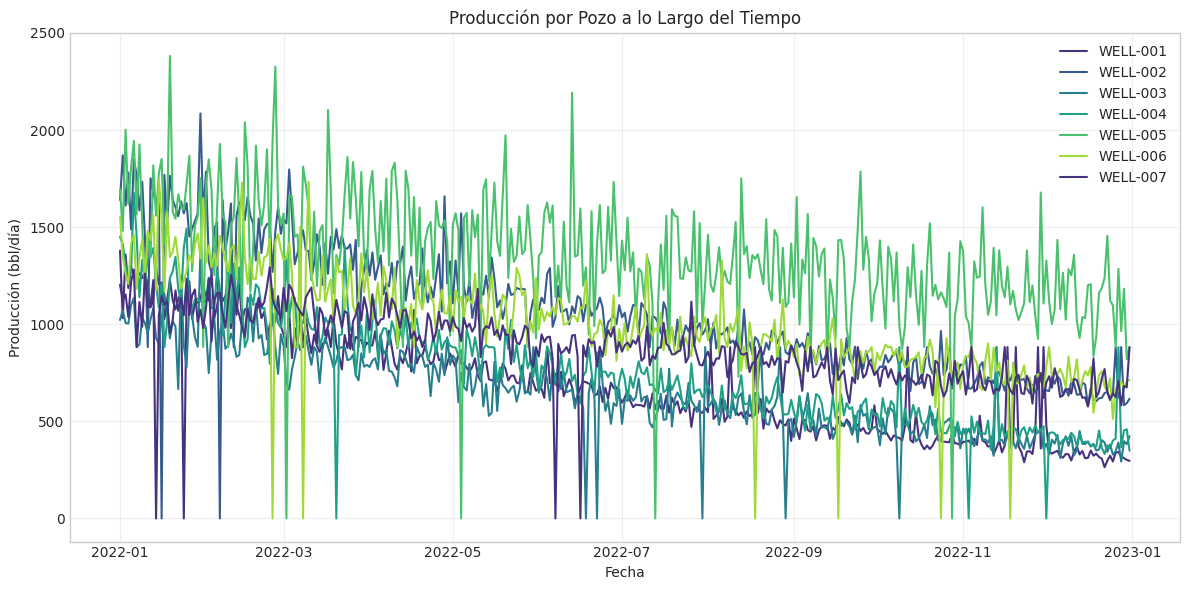

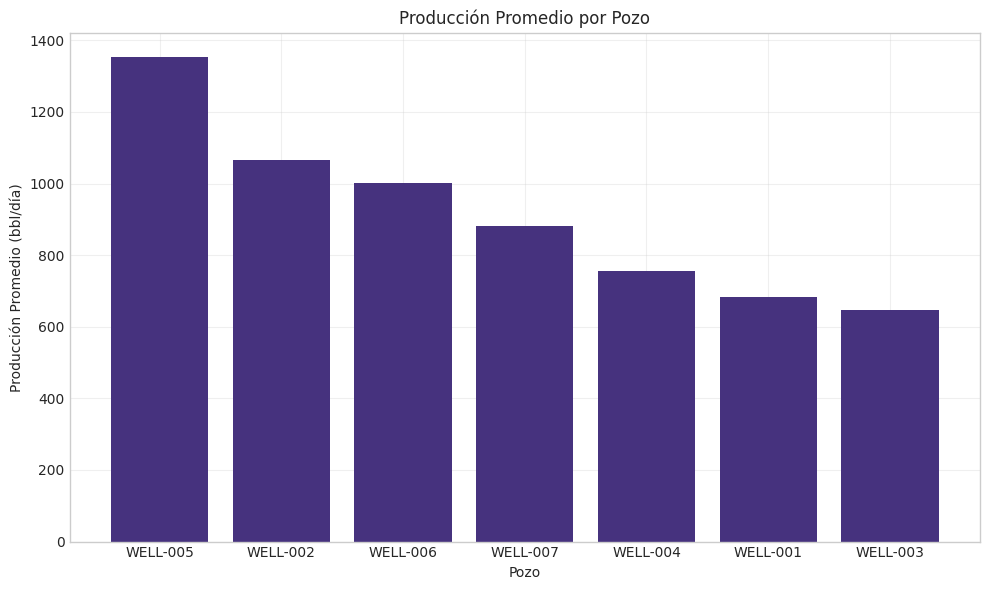

In [5]:
def plot_production_by_well(df):
    """Visualiza la producción por pozo a lo largo del tiempo."""
    plt.figure(figsize=(12, 6))
    
    # Agrupar por fecha y pozo
    for well, group in df.groupby('well_id'):
        # Ordenar por fecha
        group_sorted = group.sort_values('date')
        
        # Graficar producción
        plt.plot(group_sorted['date'], group_sorted['production'], label=well)
    
    plt.title('Producción por Pozo a lo Largo del Tiempo')
    plt.xlabel('Fecha')
    plt.ylabel('Producción (bbl/día)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calcular estadísticas por pozo
    well_stats = df.groupby('well_id')['production'].agg(['mean', 'min', 'max']).reset_index()
    
    # Graficar producción promedio por pozo
    plt.figure(figsize=(10, 6))
    
    # Graficar el top 5 de pozos por producción promedio
    well_stats = well_stats.sort_values('mean', ascending=False)
    
    plt.bar(well_stats['well_id'], well_stats['mean'])
    plt.title('Producción Promedio por Pozo')
    plt.xlabel('Pozo')
    plt.ylabel('Producción Promedio (bbl/día)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Análisis de producción por pozo
plot_production_by_well(prepared_data)

## 2.3 Análisis de correlaciones entre variables petroleras

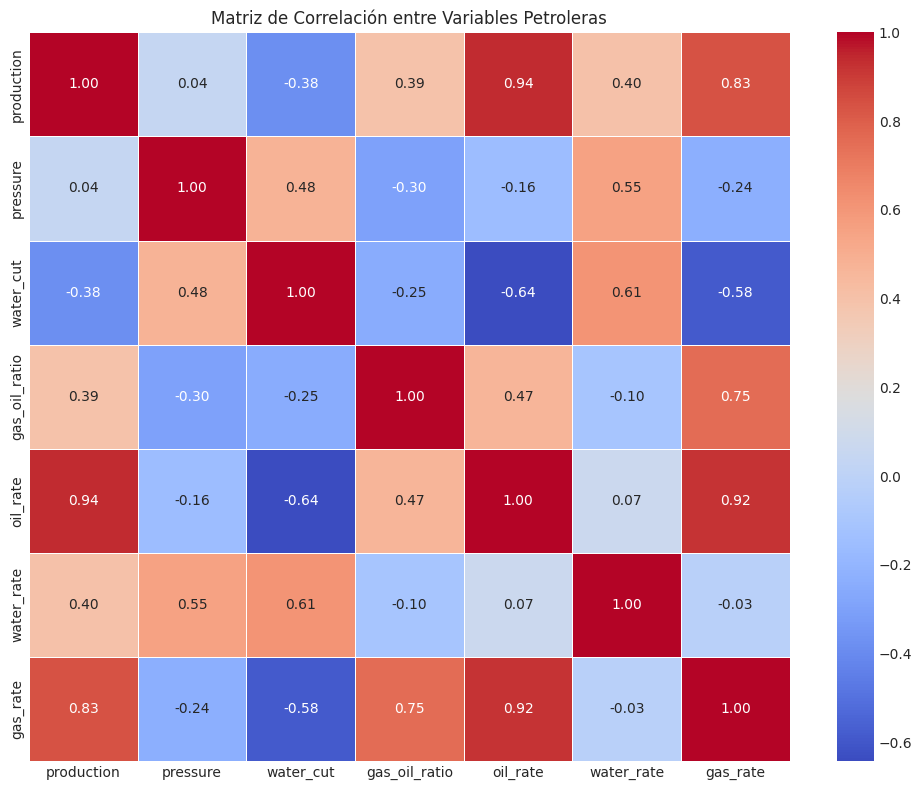

In [6]:
def analyze_petroleum_correlations(df):
    """Analiza correlaciones entre variables petroleras."""
    # Seleccionar variables numéricas relevantes
    petroleum_vars = ['production', 'pressure', 'water_cut', 'gas_oil_ratio', 
                     'oil_rate', 'water_rate', 'gas_rate']
    
    # Calcular matriz de correlación
    corr_matrix = df[petroleum_vars].corr()
    
    # Visualizar matriz de correlación
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
               linewidths=0.5)
    plt.title('Matriz de Correlación entre Variables Petroleras')
    plt.tight_layout()
    plt.show()

# Análisis de correlaciones
analyze_petroleum_correlations(prepared_data)

## 2.4 Análisis de tendencias en water cut y presión

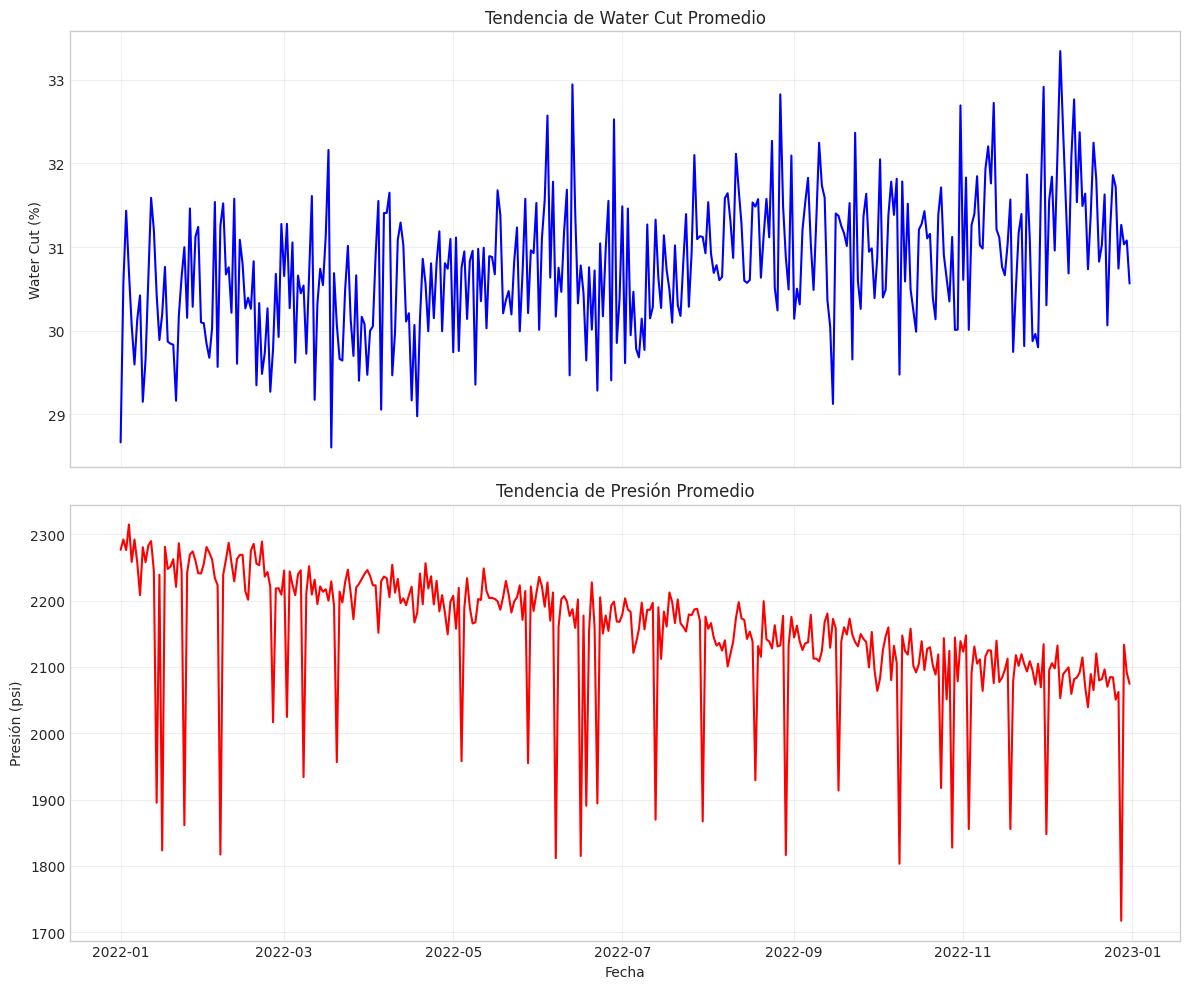

In [7]:
def analyze_trends(df):
    """Analiza tendencias en water cut y presión."""
    # Tendencias promedio a lo largo del tiempo
    # Agrupar por fecha y calcular promedios
    daily_avg = df.groupby('date').mean(numeric_only=True).reset_index()
    
    # Graficar water cut y presión promedio
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Water cut
    ax1.plot(daily_avg['date'], daily_avg['water_cut'], 'b-')
    ax1.set_title('Tendencia de Water Cut Promedio')
    ax1.set_ylabel('Water Cut (%)')
    ax1.grid(True, alpha=0.3)
    
    # Presión
    ax2.plot(daily_avg['date'], daily_avg['pressure'], 'r-')
    ax2.set_title('Tendencia de Presión Promedio')
    ax2.set_xlabel('Fecha')
    ax2.set_ylabel('Presión (psi)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Análisis de tendencias
analyze_trends(prepared_data)

# PARTE 3: VISUALIZACIONES PARA ANÁLISIS DE PRODUCCIÓN

En esta sección, desarrollaremos visualizaciones para ayudar a comprender mejor los datos de producción.

## 3.1 Relación entre water cut y producción

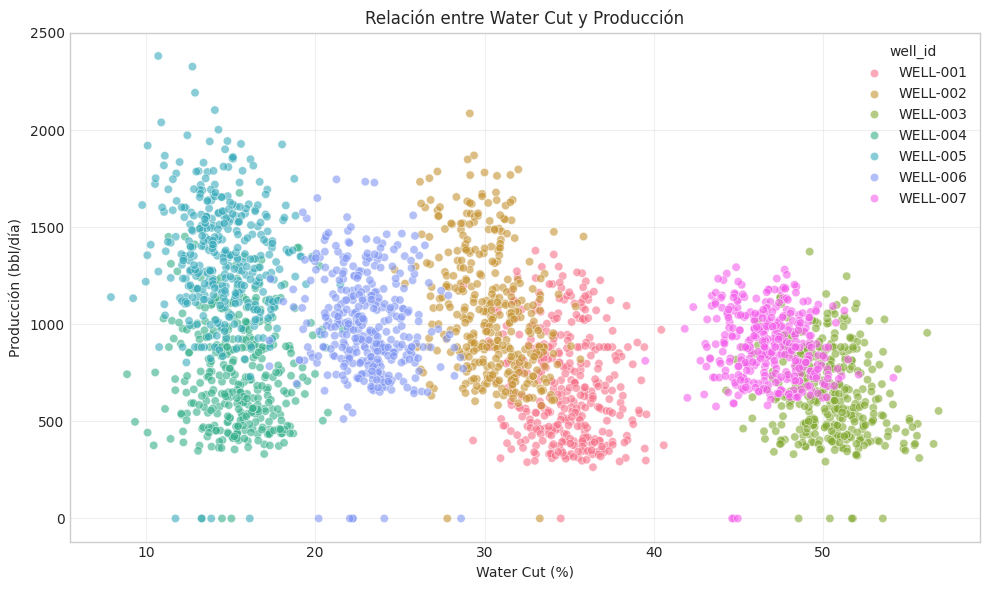

Correlación entre water cut y producción: -0.38


In [8]:
def analyze_water_cut_impact(df):
    """Analiza el impacto del water cut en la producción."""
    plt.figure(figsize=(10, 6))
    
    # Crear scatter plot
    sns.scatterplot(data=df, x='water_cut', y='production', hue='well_id', alpha=0.6)
    
    plt.title('Relación entre Water Cut y Producción')
    plt.xlabel('Water Cut (%)')
    plt.ylabel('Producción (bbl/día)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calcular correlación
    corr = df['water_cut'].corr(df['production'])
    print(f"Correlación entre water cut y producción: {corr:.2f}")

# Análisis del impacto del water cut
analyze_water_cut_impact(prepared_data)

## 3.2 Análisis de producción acumulada

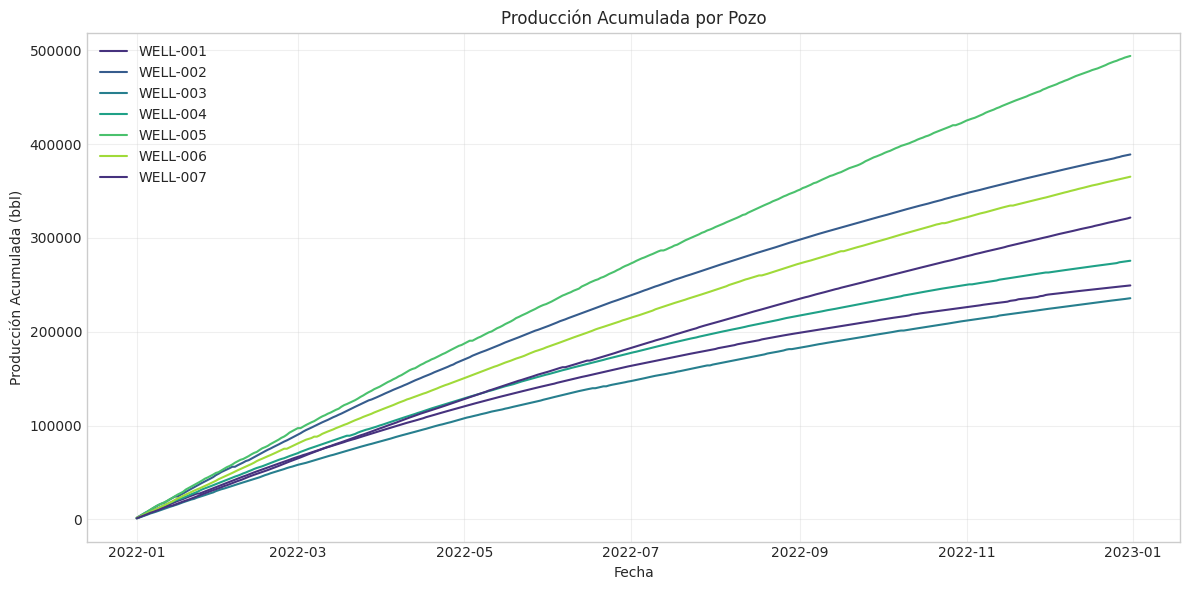

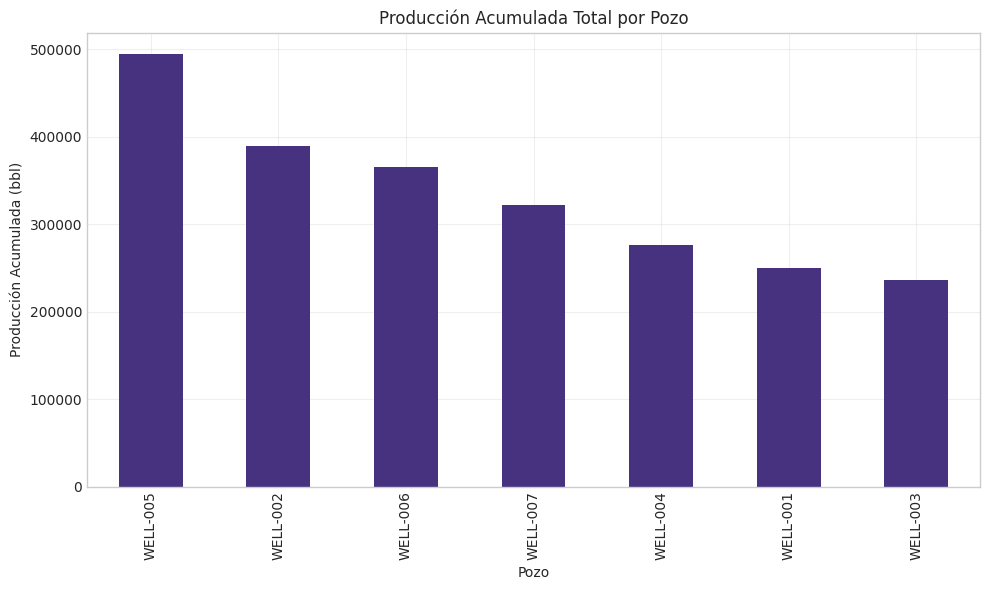

In [9]:
def analyze_cumulative_production(df):
    """Analiza la producción acumulada por pozo."""
    plt.figure(figsize=(12, 6))
    
    # Agrupar por pozo
    for well, group in df.groupby('well_id'):
        # Ordenar por fecha
        group_sorted = group.sort_values('date')
        
        # Graficar producción acumulada
        plt.plot(group_sorted['date'], group_sorted['cum_production'], label=well)
    
    plt.title('Producción Acumulada por Pozo')
    plt.xlabel('Fecha')
    plt.ylabel('Producción Acumulada (bbl)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calcular producción acumulada final por pozo
    final_cum = df.groupby('well_id')['cum_production'].max().sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    final_cum.plot(kind='bar')
    plt.title('Producción Acumulada Total por Pozo')
    plt.xlabel('Pozo')
    plt.ylabel('Producción Acumulada (bbl)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Análisis de producción acumulada
analyze_cumulative_production(prepared_data)

## 3.3 Comparación de campos petroleros

Métricas por campo:
          production_mean  production_sum  water_cut_mean  gas_oil_ratio_mean  \
field                                                                           
FIELD-01       874.348230   638274.207690       32.582160          596.553751   
FIELD-02       700.545475   511398.197046       32.918111          640.537237   
FIELD-03      1176.916886   859149.326613       18.791302          810.187900   
FIELD-04       881.282045   321667.946413       46.892914          620.603335   

          pressure_mean  
field                    
FIELD-01    2701.463082  
FIELD-02    1921.797170  
FIELD-03    1702.947525  
FIELD-04    2422.328977  


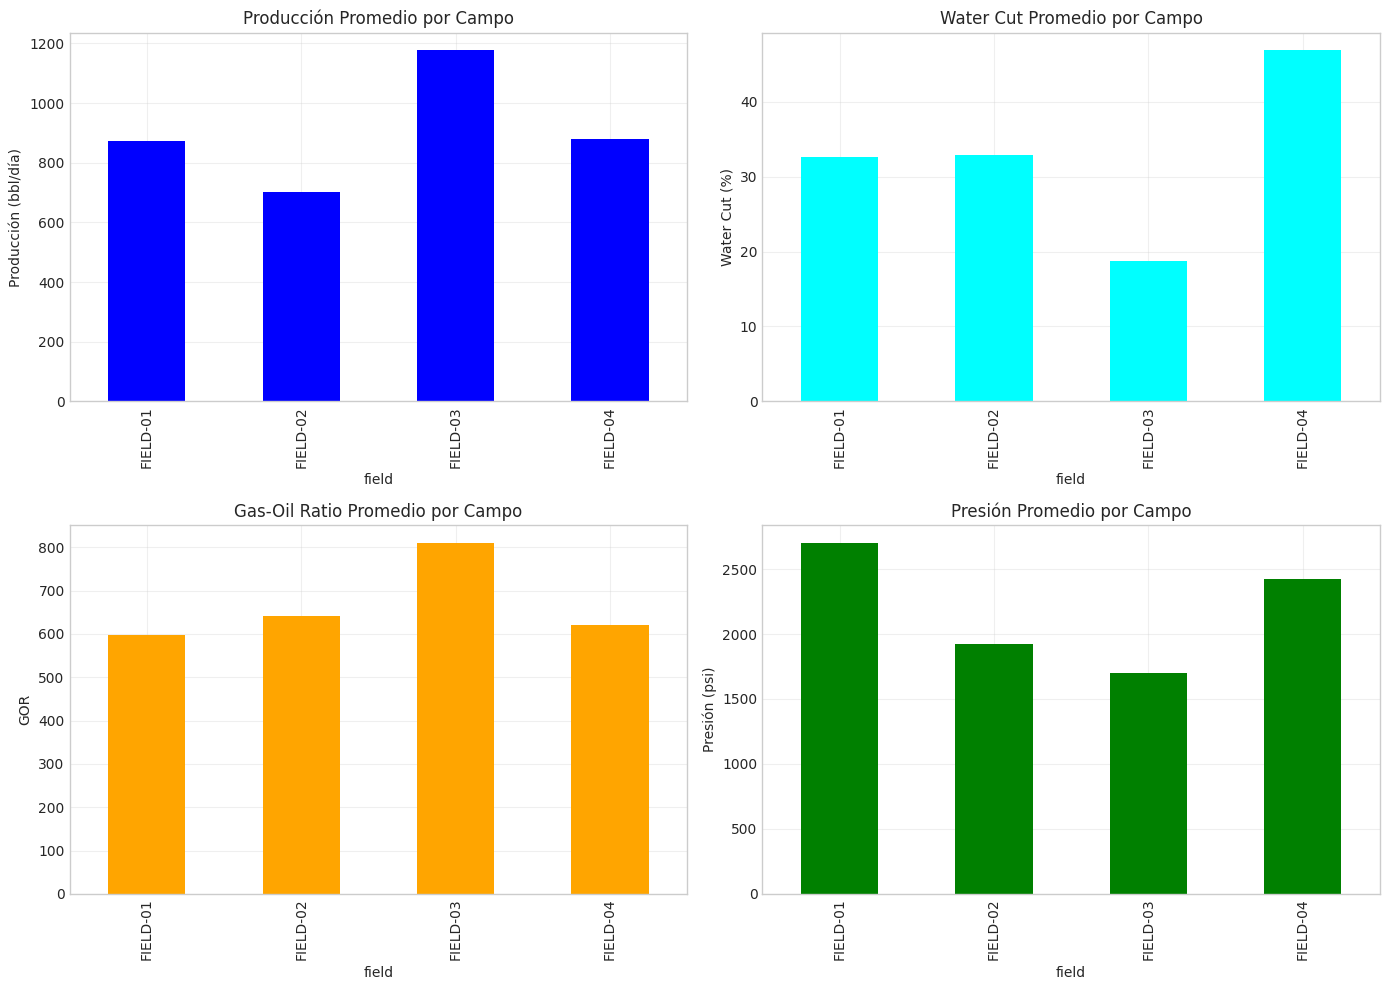

In [10]:
def compare_fields(df):
    """Compara campos petroleros en términos de producción y otros parámetros."""
    # Calcular métricas por campo
    field_metrics = df.groupby('field').agg({
        'production': ['mean', 'sum'],
        'water_cut': 'mean',
        'gas_oil_ratio': 'mean',
        'pressure': 'mean'
    })
    
    # Aplanar índice multinivel
    field_metrics.columns = ['_'.join(col).strip() for col in field_metrics.columns.values]
    
    # Mostrar métricas
    print("Métricas por campo:")
    print(field_metrics)
    
    # Graficar comparación
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Producción promedio
    field_metrics['production_mean'].plot(kind='bar', ax=axes[0, 0], color='blue')
    axes[0, 0].set_title('Producción Promedio por Campo')
    axes[0, 0].set_ylabel('Producción (bbl/día)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Water cut promedio
    field_metrics['water_cut_mean'].plot(kind='bar', ax=axes[0, 1], color='cyan')
    axes[0, 1].set_title('Water Cut Promedio por Campo')
    axes[0, 1].set_ylabel('Water Cut (%)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Gas-oil ratio promedio
    field_metrics['gas_oil_ratio_mean'].plot(kind='bar', ax=axes[1, 0], color='orange')
    axes[1, 0].set_title('Gas-Oil Ratio Promedio por Campo')
    axes[1, 0].set_ylabel('GOR')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Presión promedio
    field_metrics['pressure_mean'].plot(kind='bar', ax=axes[1, 1], color='green')
    axes[1, 1].set_title('Presión Promedio por Campo')
    axes[1, 1].set_ylabel('Presión (psi)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Comparación de campos
compare_fields(prepared_data)

# PARTE 4: ANÁLISIS DE PATRONES Y ANOMALÍAS

En esta sección, buscaremos patrones y anomalías en los datos de producción.

Detectadas 20 anomalías en los datos de producción

Ejemplos de anomalías detectadas:
           date   well_id   production         mean   z_score
380  2022-01-16  WELL-002     0.000000  1065.540401 -3.277107
394  2022-01-30  WELL-002  2085.345867  1065.540401  3.136447
401  2022-02-06  WELL-002     0.000000  1065.540401 -3.277107
759  2022-01-30  WELL-003  1373.785953   645.845243  3.248900
1100 2022-01-06  WELL-004  1676.227122   755.245708  3.278515
1478 2022-01-19  WELL-005  2381.300168  1353.171347  3.310048
1516 2022-02-26  WELL-005  2326.233055  1353.171347  3.132760
1520 2022-03-02  WELL-005     0.000000  1353.171347 -4.356518
1583 2022-05-04  WELL-005     0.000000  1353.171347 -4.356518
1653 2022-07-13  WELL-005     0.000000  1353.171347 -4.356518


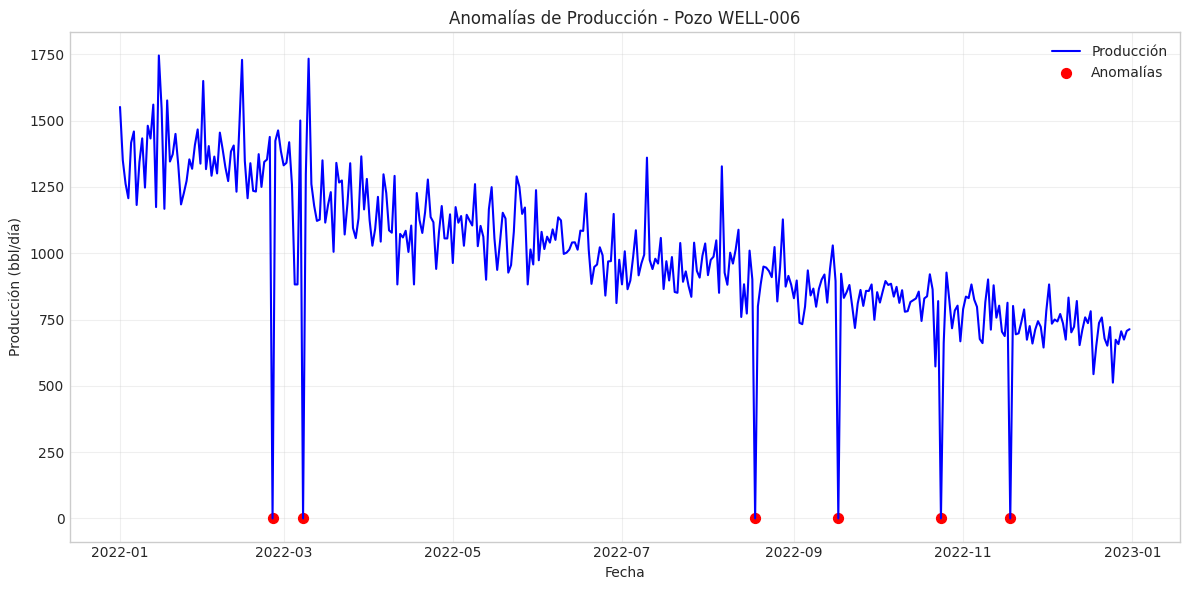

In [11]:
def detect_anomalies(df):
    """Detecta anomalías en la producción usando estadísticas básicas."""
    # Calcular estadísticas por pozo
    well_stats = df.groupby('well_id')['production'].agg(['mean', 'std']).reset_index()
    
    # Unir con datos originales
    df_with_stats = pd.merge(df, well_stats, on='well_id')
    
    # Calcular z-score para cada pozo
    df_with_stats['z_score'] = (df_with_stats['production'] - df_with_stats['mean']) / df_with_stats['std']
    
    # Identificar anomalías (z-score > 3 o z-score < -3)
    anomalies = df_with_stats[abs(df_with_stats['z_score']) > 3].copy()
    
    print(f"Detectadas {len(anomalies)} anomalías en los datos de producción")
    
    if len(anomalies) > 0:
        # Mostrar algunas anomalías
        print("\nEjemplos de anomalías detectadas:")
        print(anomalies[['date', 'well_id', 'production', 'mean', 'z_score']].head(10))
        
        # Graficar anomalías para un pozo de ejemplo
        sample_well = anomalies['well_id'].value_counts().index[0]
        
        plt.figure(figsize=(12, 6))
        
        # Datos del pozo
        well_data = df_with_stats[df_with_stats['well_id'] == sample_well].sort_values('date')
        plt.plot(well_data['date'], well_data['production'], 'b-', label='Producción')
        
        # Anomalías
        well_anomalies = anomalies[anomalies['well_id'] == sample_well]
        plt.scatter(well_anomalies['date'], well_anomalies['production'], 
                   color='red', s=50, label='Anomalías')
        
        plt.title(f'Anomalías de Producción - Pozo {sample_well}')
        plt.xlabel('Fecha')
        plt.ylabel('Producción (bbl/día)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Detección de anomalías
detect_anomalies(prepared_data)

# REFLEXIÓN Y APLICACIÓN

En este laboratorio, hemos explorado un conjunto de datos de producción petrolera sintético utilizando técnicas de análisis exploratorio. A continuación se presentan algunas conclusiones y aplicaciones prácticas.

## Resumen de hallazgos y aplicaciones

1. **Patrones de producción**
   - La producción sigue una tendencia de declinación natural en la mayoría de los pozos
   - Existen diferencias significativas en la producción entre diferentes campos
   - Algunos pozos muestran eventos de shutdown y workover que impactan la producción

2. **Relaciones entre variables**
   - La relación entre water cut y producción varía por pozo
   - La presión tiene una correlación importante con la producción
   - El gas-oil ratio muestra patrones interesantes que podrían indicar cambios en el reservorio

3. **Aplicaciones prácticas**
   - Identificación de pozos con oportunidades de optimización
   - Detección temprana de problemas de producción mediante análisis de anomalías
   - Comparación de rendimiento entre campos para priorizar inversiones
   - Predicción de tendencias futuras de producción y water cut

## Preguntas para reflexionar

1. ¿Qué otros factores podrían estar influyendo en la producción que no están capturados en nuestros datos?

2. ¿Cómo podríamos mejorar nuestro análisis para detectar eventos de workover con mayor precisión?

3. ¿Qué modelos predictivos serían más adecuados para pronosticar la producción futura basándose en los patrones identificados?

4. ¿Cómo podríamos incorporar datos geológicos o de completación de pozos para enriquecer el análisis?

## Próximos pasos

Para profundizar en el análisis de datos petroleros, podrías considerar:

1. Aplicar técnicas más avanzadas de detección de anomalías (DBSCAN, Isolation Forest)
2. Desarrollar modelos de declinación para pronosticar producción futura
3. Implementar análisis de series temporales para identificar patrones estacionales
4. Crear dashboards interactivos para monitoreo continuo de la producción